In [ ]:
!pip install numpy pandas pyathena matplotlib seaborn

## Imports

In [35]:
import pandas as pd
from pyathena import connect
# visual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Query Athena

In [36]:
# connect to athena
s3_staging_dir = 's3://camma-lab4/query-results/'
conn = connect(s3_staging_dir=s3_staging_dir, schema_name='cama_emission_data_db', region_name='us-east-1')

In [50]:
ath_query = """
SELECT vehicle_id, vehicle_co2, vehicle_speed, vehicle_type, vehicle_eclass,
  partition_3 AS hour,
  CAST(concat(partition_0, '-', partition_1, '-', partition_2, ' ', partition_3, ':00:00') AS timestamp) AS timestamp
FROM raw_data;
"""

In [51]:
# run the qeury
df = pd.read_sql(ath_query, conn)

/tmp/ipykernel_2738/4051914594.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(ath_query, conn)


In [52]:
# view
df.head()

,vehicle_id,vehicle_co2,vehicle_speed,vehicle_type,vehicle_eclass,hour,timestamp
0,veh3,5632.23,9.72,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
1,veh3,6649.58,11.25,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
2,veh3,0.00,11.22,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
3,veh3,5645.06,12.29,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
4,veh3,0.00,11.97,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00


### Edit the data fromat

In [53]:
df['vehicle_co2'] = pd.to_numeric(df['vehicle_co2'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [54]:
df.head()

,vehicle_id,vehicle_co2,vehicle_speed,vehicle_type,vehicle_eclass,hour,timestamp
0,veh3,5632.23,9.72,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
1,veh3,6649.58,11.25,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
2,veh3,0.00,11.22,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
3,veh3,5645.06,12.29,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00
4,veh3,0.00,11.97,veh_passenger,HBEFA3/PC_G_EU4,23,2024-11-17 23:00:00


In [55]:
#check the null values
df.isnull().sum()

vehicle_id        0
vehicle_co2       0
vehicle_speed     0
vehicle_type      0
vehicle_eclass    0
hour              0
timestamp         0
dtype: int64

In [56]:
# drop null
df.dropna(subset=['vehicle_id', 'vehicle_co2'], inplace=True)

## Visual

### Distribution of CO2 - Overall

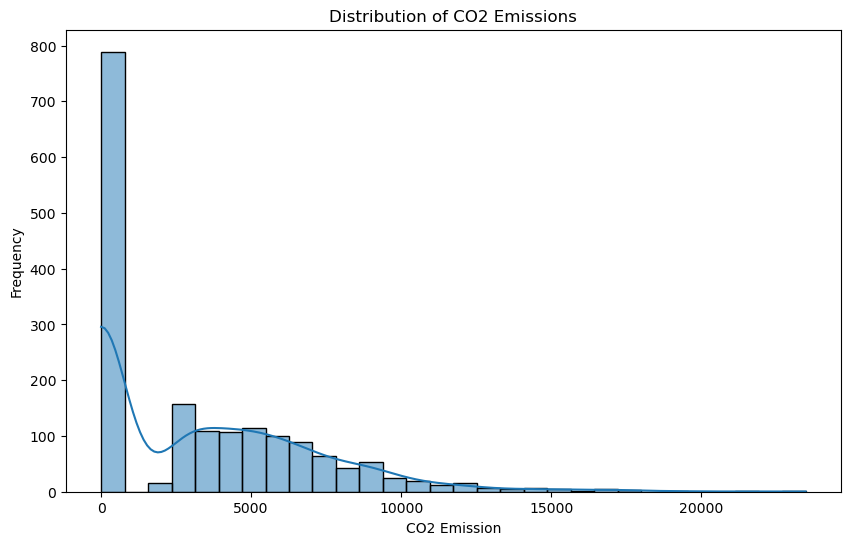

In [44]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='vehicle_co2', bins=30, kde=True)
# titles
plt.title('Distribution of CO2 Emissions')
plt.xlabel('CO2 Emission')
plt.ylabel('Frequency')
plt.show()

###  CO2 Emission by Vehicle

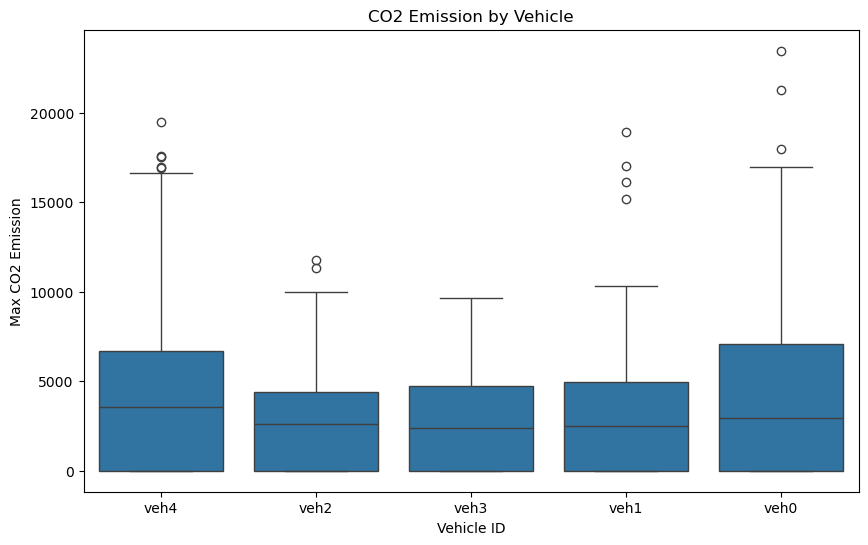

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='vehicle_id', y='vehicle_co2')
plt.title('CO2 Emission by Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Max CO2 Emission')
plt.show()

### Emissions by Vehicle Type

/tmp/ipykernel_2738/3564150901.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='vehicle_type', y='vehicle_co2', ci=None, estimator='mean')


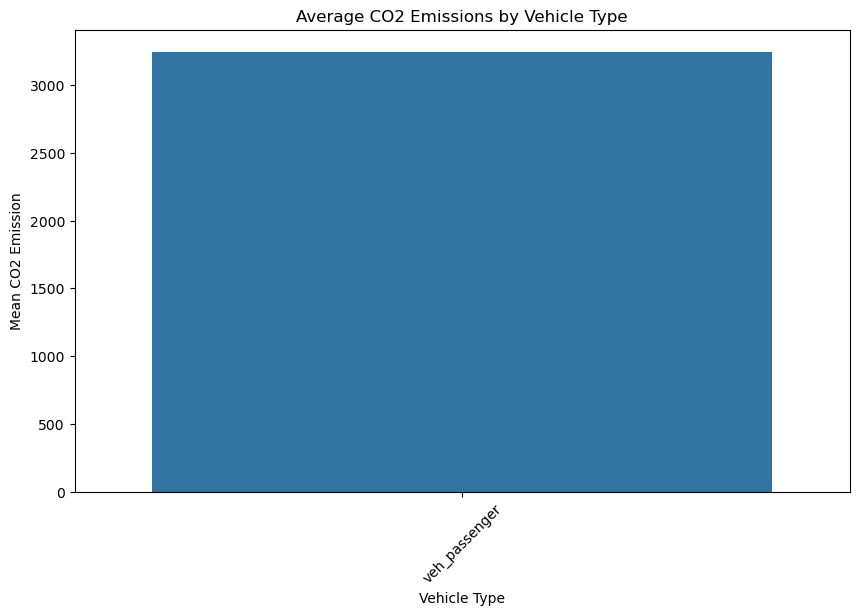

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='vehicle_type', y='vehicle_co2', ci=None, estimator='mean')
plt.title('Average CO2 Emissions by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Mean CO2 Emission')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_2738/3052141878.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='vehicle_eclass', y='vehicle_co2', ci=None, estimator='mean')


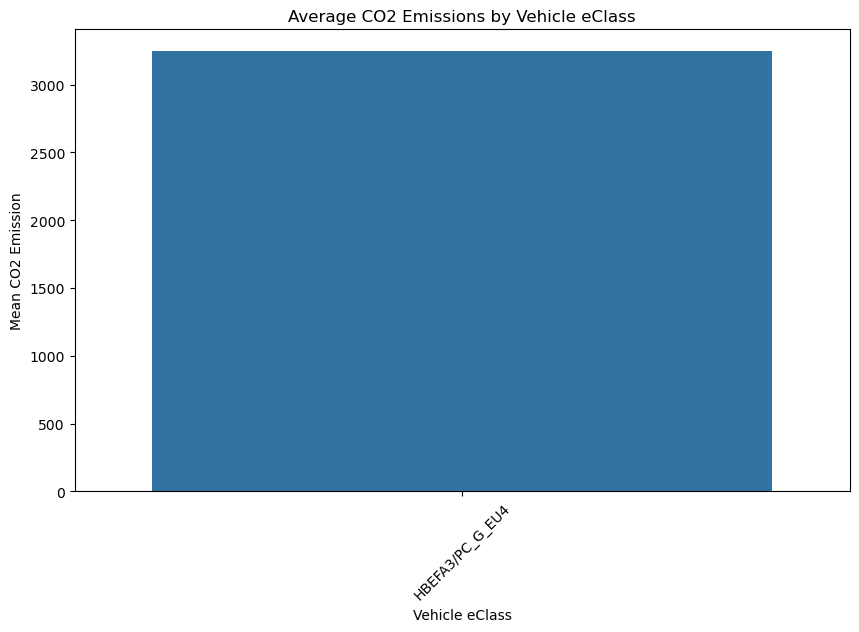

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='vehicle_eclass', y='vehicle_co2', ci=None, estimator='mean')
plt.title('Average CO2 Emissions by Vehicle eClass')
plt.xlabel('Vehicle eClass')
plt.ylabel('Mean CO2 Emission')
plt.xticks(rotation=45)
plt.show()

### CO2 Emission Over Hours 

In [47]:
aggregated_df = df.groupby(['vehicle_id', 'hour', 'timestamp']).agg({'vehicle_co2': 'mean'}).reset_index()

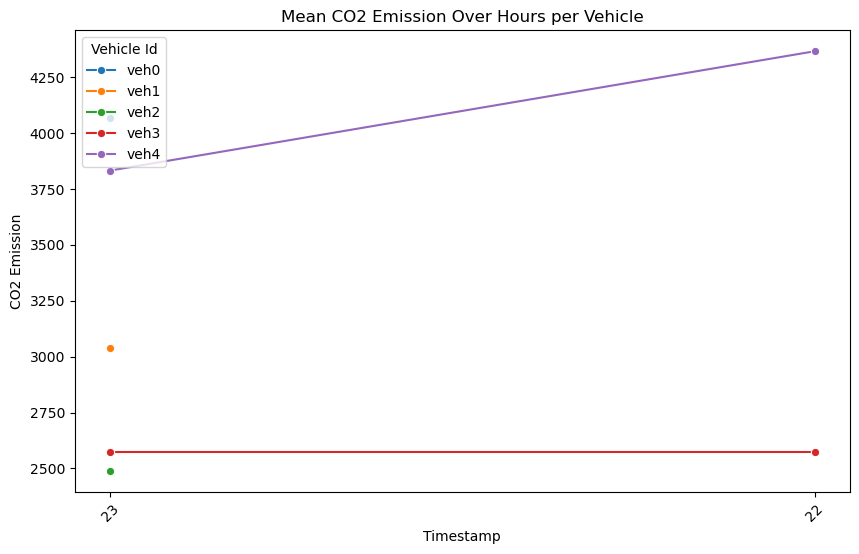

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_df, x='hour', y='vehicle_co2', hue='vehicle_id', marker='o')
# titles
plt.title('Mean CO2 Emission Over Hours per Vehicle')
plt.xlabel('Timestamp')
plt.ylabel('CO2 Emission')
# setting
plt.legend(title='Vehicle Id', loc='upper left')
plt.xticks(rotation=45)
plt.show()

### Relation between speed and emission

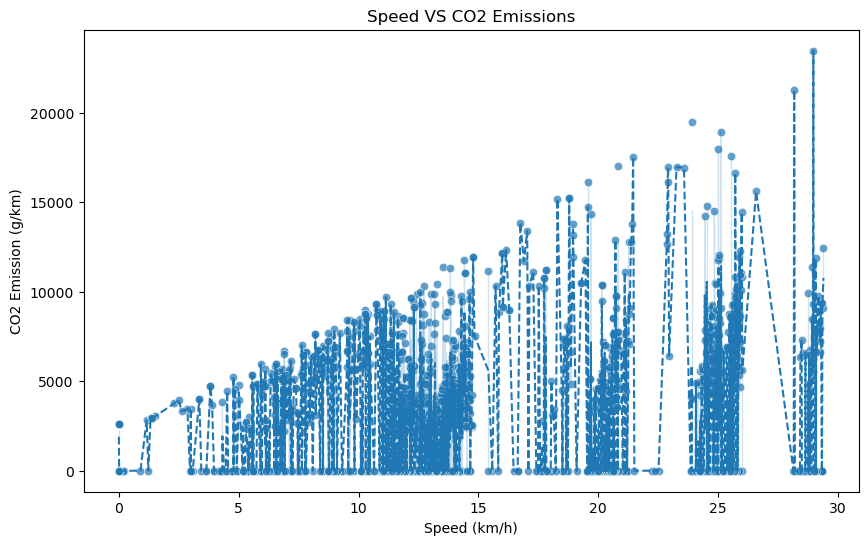

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='vehicle_speed', y='vehicle_co2', alpha=0.7)
sns.lineplot(
    data=df, x='vehicle_speed', y='vehicle_co2', hue='vehicle_type', 
    estimator='mean', legend=False,linestyle='--'
)
plt.title('Speed VS CO2 Emissions')
plt.xlabel('Speed (km/h)')
plt.ylabel('CO2 Emission (g/km)')
plt.show()